# Coulomb tests

**AIM**: Sweep the SET to measure coulomb blocking using RF. This has already been done with LabOneQ but we want to recreate it with zurich-instruments directly.

In [26]:
%matplotlib inline
import local_broom

In [27]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import time
from monty import Monty

## Setup

In [161]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

# connect to data server
session = Session(SERVER_HOST)

# connect to device
device = session.connect_device(DEVICE_ID)

In [186]:
#session.disconnect_device(DEVICE_ID)

In [163]:
experiment = {
    "desc": "Measure coulomb peaks."
}

monty = Monty("rf.detuning", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 256


### Variables

**TODO**: Reformat this into a directory for lookup later

In [164]:
##### gate sampling time
samplingDivider = 6

# setup averaging. It is faster to run averages on the device but no feedback can take place
averages = 1  # python averages
seq_averages = 200  # seqc averages

# readout signals
readout_gain = 0.95  # If we set this to 1, then output overloads
readout_freq = 406.6e6  # (Hz) 406.6

# drive line amplitudes (maximum 340mV, give in terms of V)
dr_start = -0.1  # start and end voltages applied to ST
dr_end = 0.1
num_pulses = 100  # number of unique waveforms to generate

# powers
input_pwr = 5
output_pwr = -10
dr_pwr = -5

# timings in seconds
prior_time = 10e-6  # A time
read_time = 25e-6  # integration time
buffer_time = 1000e-6  # note actual pulse time is buffer_time*2+read_time for ST, and only read_time for ACQ
trigger_time = 2.5e-3  # internal trigger holdoff time (metronome)

In [165]:
# generated variables
pulse_time = buffer_time*2 + read_time

### Functions

In [166]:
def timeToSamples(time, samplingRateDivider):
    # returns the number of samples divisible by 16 given a time (in seconds) and sampling rate divider
    samples_raw = time * (1/(2**samplingRateDivider))/0.5e-9
    samples_modulo = int(samples_raw) % 16
    samples = int(samples_raw) - int(samples_modulo)
    return samples

# custom curve fit
amps = [1, 0.85, 0.75, 0.65,  0.5, 0.35, 0.25, 0.2, 0.125, 0.05]
voltages = [0.34, 0.268, 0.207, 0.158, 0.094, 0.0481,  0.026, 0.0183, 0.01, 0.0057]

alt_fit = np.poly1d(np.polyfit(amps, voltages, 2))
# Hard coding alt_fit values in case something goes horribly wrong

def voltToDbm(volt, dbmrange):
    # Ok yes this can be better, deal with it
    if dbmrange != 0:
        raise Exception("This function only works with a dBm range of 0.")
    
    if volt > 0.34 or volt < -0.34:
        raise ValueError(f"Given voltage ({volt} V) is greater than max output of SHFQC (0.34 V)")
    
    if volt < 0:
        amplitude = 1/300*(np.sqrt(3e5*-volt + 529) - 23)
        return -amplitude
    else:
        amplitude = 1/300*(np.sqrt(3e5*volt + 529) - 23)
        return amplitude


def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                # total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

def cmdtable(ct, amplitude, length, wave_index, ct_index):
    """
    Load a default command table with a sin/cos wave (used throughout the documentation)
    """
    ct.table[ct_index].waveform.index = wave_index
    ct.table[ct_index].amplitude00.value = amplitude  # all in dBm
    ct.table[ct_index].amplitude01.value = -amplitude
    ct.table[ct_index].amplitude10.value = amplitude
    ct.table[ct_index].amplitude11.value = amplitude
    ct.table[ct_index].waveform.length = length  # in samples
    ct.table[ct_index].waveform.samplingRateDivider = samplingDivider  # inherit global

### Setup channels

In [167]:
# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "ST": device.sgchannels[0],
    "P1": device.sgchannels[1],  # drive P1 line
    "P2": device.sgchannels[2],  # drive P2 line
    "J": device.sgchannels[3],  # drive P2 line
}

drive_chans = ["ST"]  # match keys above

In [168]:
for i in range(6):
    device.sgchannels[i].synchronization.enable(0)

In [169]:
with device.set_transaction():
    # setup drive channels
    for c in drive_chans:
        chan[c].output.range(dr_pwr)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
        chan[c].output.on(1)  # enable output
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        chan[c].marker.source(0)  # setup the AWG trigger 1 (is this an input trigger option? doesn't seem necessary)
        # see manual page p235 for all trigger options
        chan[c].awg.auxtriggers[0].channel(8)  # 8=use internal trigger, 1024=use software trigger

    # setup measure channel
    
    chan["measure"].output.rflfpath(0)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(0)
    chan["measure"].oscs[0].freq(readout_freq)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(readout_gain)  # If we set this to 1, then output overloads

    # configure these based on how the sweeper works internally
    # See https://docs.zhinst.com/zhinst-utils/en/latest/_modules/zhinst/utils/shf_sweeper.html#ShfSweeper
    chan["measure"].spectroscopy.delay(0)  # integration delay in units of second
    chan["measure"].spectroscopy.length(25e-6*2e9)  # integration time length in units of number of samples (usually integration_time*sampling_rate)
    # setup when the spectroscopy is triggered
    chan["measure"].spectroscopy.trigger.channel("chan0seqtrig0")  # make sure to use the trigger coming from the sequencer code
    # setup result parameters
    chan["measure"].spectroscopy.result.averages(1)  # number of averages (always average in software not hardware)
    chan["measure"].spectroscopy.result.length(num_pulses*seq_averages)  # number of results
    chan["measure"].spectroscopy.result.mode("sequential")
    chan["measure"].spectroscopy.result.enable(0)  # disable result logger

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz for RF mode
        input_range=input_pwr,  # in units of dBm
        output_range=output_pwr,  # in units of dBm
        mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

    chan["measure"].generator.auxtriggers[1].channel("inttrig")  # i believe this is overwritten by the following line
    chan["measure"].generator.configure_sequencer_triggering(
        aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
        play_pulse_delay=0
    )


### Sequencer code

In [170]:
# use the same waveforms for all sequence programs
st_prog_code = f"""

// Assign a single channel waveform to wave table entry 0
wave w_a = ones({timeToSamples(pulse_time, samplingDivider)});
assignWaveIndex(1,2, w_a, 0);

// Reset the oscillator phase
resetOscPhase();

repeat({seq_averages}) {{
    for (var i = 0; i < {num_pulses}; i++) {{
        waitDigTrigger(1);
        
        setTrigger(1);  // Trigger the scope
        setTrigger(0);
    
        // playZero({timeToSamples(prior_time, samplingDivider)}, {samplingDivider});
        // playZero(32);
        executeTableEntry(i);
    }}
}}
"""

readout_prog_code = f"""
setTrigger(0); // Set low as this starts the spectroscopy readout....

repeat({seq_averages}) {{
    for (cvar i = 0.0; i < {num_pulses}; i++) {{
        waitDigTrigger(1);
    
        // playZero(32); // lineup with SG trigger (224 samples = lines up with SG trigger)
        
        playZero({timeToSamples(buffer_time*2, samplingDivider)}, {samplingDivider});
        playZero(32);

    
        //playZero({timeToSamples(read_time, samplingDivider)}, {samplingDivider});  // non-blocking, so skipped
        setTrigger(1);  // trigger the output. As this matches "chan0seqtrig0" the spectroscopy is started
        setTrigger(0);
    }}
}}
"""

In [171]:
# upload waveforms to instrument

# load ST driver
print(f"_________ {chan["ST"]} _________")
print(st_prog_code)
print(chan["ST"].awg.load_sequencer_program(st_prog_code))

# upload measure code
print(f"_________  {chan["measure"]}  _________")
print(readout_prog_code)
print(chan["measure"].generator.load_sequencer_program(readout_prog_code))

_________ /dev12158/sgchannels/0 _________


// Assign a single channel waveform to wave table entry 0
wave w_a = ones(63280);
assignWaveIndex(1,2, w_a, 0);

// Reset the oscillator phase
resetOscPhase();

repeat(100) {
    for (var i = 0; i < 100; i++) {
        waitDigTrigger(1);
        
        setTrigger(1);  // Trigger the scope
        setTrigger(0);
    
        // playZero(304, 6);
        // playZero(32);
        executeTableEntry(i);
    }
}

{'messages': '', 'maxelfsize': 2147483648}
_________  /dev12158/qachannels/0  _________

setTrigger(0); // Set low as this starts the spectroscopy readout....

repeat(100) {
    for (cvar i = 0.0; i < 100; i++) {
        waitDigTrigger(1);
    
        // playZero(32); // lineup with SG trigger (224 samples = lines up with SG trigger)
        
        playZero(62496, 6);
        playZero(32);

    
        //playZero(768, 6);  // non-blocking, so skipped
        setTrigger(1);  // trigger the output. As this matches "chan0seqtrig0" the 

### Setup command tables

Each command table for every pulse

In [172]:
# COMMAND TABLES

pulse_amps = np.linspace(dr_start, dr_end, num_pulses)

schema = chan["ST"].awg.commandtable.load_validation_schema()
ct = CommandTable(schema)

output_dbm = chan["ST"].output.range()
for i, pulse_amp in enumerate(pulse_amps):
    cmdtable(ct,
             amplitude= pulse_amps[i],
             length=timeToSamples(pulse_time, samplingDivider),
             wave_index=0,
             ct_index=i,
            )
chan["ST"].awg.commandtable.upload_to_device(ct)

### Setup internal trigger

In [173]:
device.system.internaltrigger.repetitions(num_pulses*seq_averages)  # make sure that this matches how many pulses we are sending
device.system.internaltrigger.holdoff(trigger_time)  # init_len + 2*wait_and_settle + 100e-6*2)  # how long to wait between retriggers (increments of 100ns)

## Run

In [174]:
# setup channel synchronization
chan["measure"].synchronization.enable(1)
chan["ST"].synchronization.enable(1)
chan["P1"].synchronization.enable(0)
chan["P2"].synchronization.enable(0)
chan["J"].synchronization.enable(0)
device.system.internaltrigger.synchronization.enable(1)

Started new run coulomb.76


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

24.978155374526978
Sequencers in unknown state. Perhaps they are not synchronised? 0, 0
Run finished and took 0:00:27.940180.
Saving to coulomb.76.xz
Saving to experiment.yaml


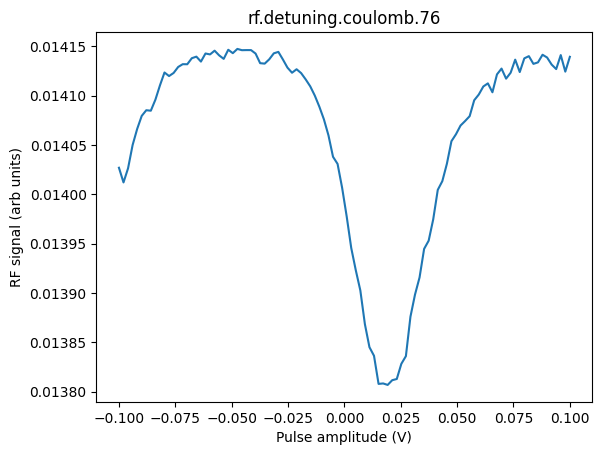

In [183]:
data = np.zeros((averages, num_pulses), dtype=np.complex64)

monty.newrun("coulomb", {})

for avg in tqdm(range(averages)):
    #print(f"AVG={avg}")
    device.system.internaltrigger.enable(0)
    
    result_node = chan["measure"].spectroscopy.result.data.wave
    result_node.subscribe()
    
    chan["measure"].spectroscopy.result.enable(1)  # start logger
    
    # start sequencers
    chan["measure"].generator.enable_sequencer(single=True)
    chan["ST"].awg.enable_sequencer(single=True)  # dont want to repeat
    
    # start triggering sequence (which starts each sequencer)
    device.system.internaltrigger.enable(1)
    time.sleep(0.1)
    
    # wait for the measurement to complete
    tic = time.time()
    pbar = tqdm(total=100)
    while device.system.internaltrigger.progress() != 1.0:
        p = int(device.system.internaltrigger.progress()*100)
        pbar.update(p-pbar.n)
        time.sleep(0.001)
    pbar.update(100-pbar.n)
    pbar.close()
    print(time.time()-tic)

    # time.sleep(0.1)
    m_state = chan["measure"].generator.sequencer.status()
    st_state = chan["ST"].awg.sequencer.status()
    if m_state != 4 and st_state != 4:
        print(TimeoutError(f"Sequencers in unknown state. Perhaps they are not synchronised? {m_state}, {st_state}"))
        time.sleep(0.5)
    
    # chan["measure"].spectroscopy.result.enable(0)  # stop data logger
    
    #device.system.internaltrigger.enable(0)

    # wait for completion
    while chan["measure"].spectroscopy.result.enable() != 0:
        print(chan["measure"].spectroscopy.result.enable())
        chan["measure"].spectroscopy.result.enable.wait_for_state_change(0, timeout=10)
        time.sleep(0.01)

    
    # get results
    results = get_results(result_node, timeout=5)
    result_node.unsubscribe()

    # verify results
    acq = chan["measure"].spectroscopy.result.acquired()
    if len(results) > acq:
        print(chan["measure"].generator.ready())
        print(chan["ST"].awg.ready())
        print(bin(chan["measure"].generator.sequencer.status()))
        print(bin(chan["ST"].awg.sequencer.status()))

        # Status of the Sequencer on the instrument.
        # Bit 0: Sequencer is running;
        # Bit 1: reserved;
        # Bit 2: Sequencer is waiting for a trigger to arrive;
        # Bit 3: Sequencer has detected an error;
        # Bit 4: sequencer is waiting for synchronization with other channels
        raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")

    # remove sequence averaging
    data[avg] = np.mean(results.reshape((seq_averages, num_pulses)), axis=0)

time.sleep(1)
# chan["measure"].input.on(0)
# chan["measure"].output.on(0)

res = np.mean(data, axis=0)
plt.plot(pulse_amps, np.abs(res))
plt.xlabel("Pulse amplitude (V)")
plt.ylabel("RF signal (arb units)")
plt.title(monty.identifier + "." + monty.runname)

monty.save({"data": res})
monty.savefig(plt, "ramp decay")

In [184]:
Xr = res #np.real(res)
amplitude = 10*np.log10(np.abs(Xr)**2/50*1000)
phase = np.unwrap(np.angle(Xr))

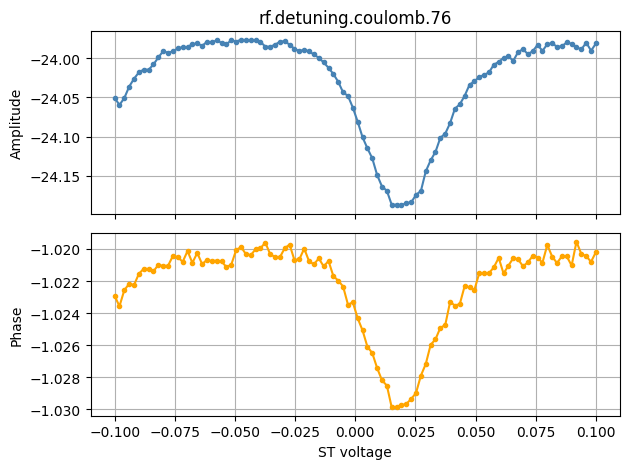

In [185]:
fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

ax0.plot(pulse_amps, amplitude, ".-", color="steelblue")
ax1.plot(pulse_amps, phase, ".-", color="orange")

ax0.set_ylabel("Amplitude")
ax1.set_ylabel("Phase")
ax0.set_title(monty.identifier + "." + monty.runname )
ax1.set_xlabel("ST voltage")

ax0.grid()
ax1.grid()

fig.align_ylabels([ax0, ax1])
plt.tight_layout()

monty.savefig(plt, "SET sweep")

In [178]:
voltToDbm(0.25, 0)

0.8394179970577684

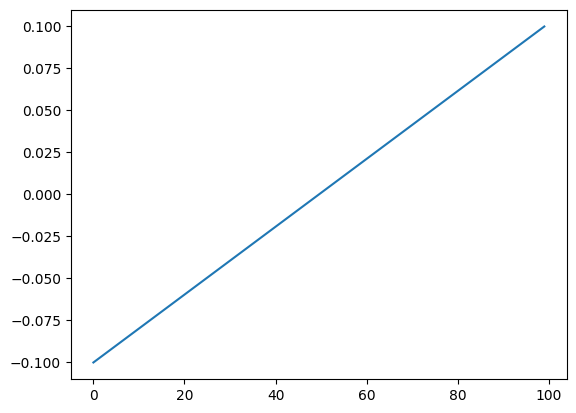

In [179]:
plt.plot(pulse_amps)

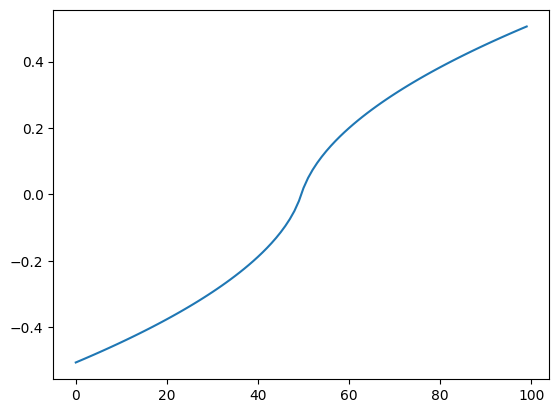

In [180]:
arr = np.zeros(len(pulse_amps))
for i, val in enumerate(pulse_amps):
    arr[i] = voltToDbm(val, 0)

plt.plot(arr)

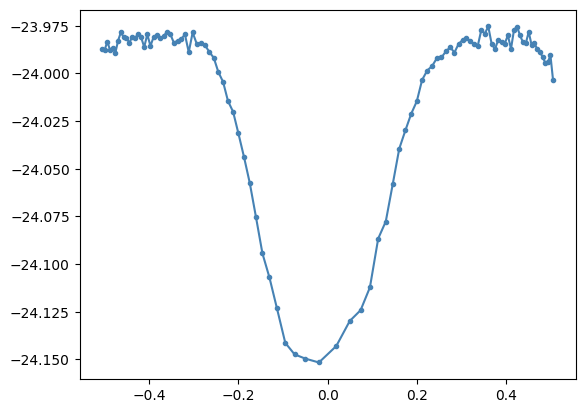

In [181]:
plt.plot(arr, amplitude, ".-", color="steelblue")